In [1]:
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, matthews_corrcoef, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve, r2_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Load the cleaned dataframe
df = pd.read_csv('data_2018_2023_chl_sst_sswh_clean.csv')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Summary statistics
summary_stats = df.describe()
print(summary_stats)

df.drop(columns=['time'], inplace=True)

C:\Users\marko\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Missing Values:
 time                0
VHM0                0
VTM02               0
VTM10               0
VMDR                0
VPED                0
VTPK                0
VCMX                0
VMXL                0
VHM0_WW             0
VHM0_SW1            0
VHM0_SW2            0
VMDR_WW             0
VMDR_SW1            0
VMDR_SW2            0
VTM01_WW            0
VTM01_SW1           0
VTM01_SW2           0
VSDX                0
VSDY                0
analysed_sst        0
analysis_error      0
mask                0
sea_ice_fraction    0
longitude           0
latitude            0
depth               0
po4                 0
phyc                0
si                  0
nh4                 0
chl                 0
fe                  0
no3                 0
nppv                0
zeu                 0
o2                  0
spco2               0
dissic              0
ph                  0
dtype: int64
               VHM0         VTM02         VTM10          VMDR          VPED  \
count  2.18

In [2]:
df.dtypes

VHM0                float64
VTM02               float64
VTM10               float64
VMDR                float64
VPED                float64
VTPK                float64
VCMX                float64
VMXL                float64
VHM0_WW             float64
VHM0_SW1            float64
VHM0_SW2            float64
VMDR_WW             float64
VMDR_SW1            float64
VMDR_SW2            float64
VTM01_WW            float64
VTM01_SW1           float64
VTM01_SW2           float64
VSDX                float64
VSDY                float64
analysed_sst        float64
analysis_error      float64
mask                float64
sea_ice_fraction    float64
longitude           float64
latitude            float64
depth               float64
po4                 float64
phyc                float64
si                  float64
nh4                 float64
chl                 float64
fe                  float64
no3                 float64
nppv                float64
zeu                 float64
o2                  

In [3]:
# Compute percentiles
p25, p50, p75 = np.percentile(df['chl'], [25, 50, 75])
print(f"25th: {p25:.2f}, 50th: {p50:.2f}, 75th: {p75:.2f}")

# Keep only rows with chl > 25th percentile
df_filtered = df[df['chl'] > p25].copy()

# Categorize
df_filtered['algae_category'] = np.where(
    df_filtered['chl'] > p75, 'High',
    np.where(df_filtered['chl'] > p50, 'Medium', 'Low')
)

# Check distribution
print("Class distribution:\n", df_filtered['algae_category'].value_counts())

# Prepare predictors and target
predictors = df_filtered.drop(columns=['chl', 'algae_category'])
predictors = predictors.select_dtypes(include=[np.number])

target = df_filtered['algae_category']

# Encode and scale
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(target)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(predictors)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target_encoded, test_size=0.3, stratify=target_encoded, random_state=42
)

# Confirm result
print(f"Training Data Shape: {X_train.shape}, Test Data Shape: {X_test.shape}")
print(f"Target Classes: {encoder.classes_}")

25th: 0.00, 50th: 0.06, 75th: 0.10
Class distribution:
 algae_category
Medium    509788
High      489173
Low       442945
Name: count, dtype: int64
Training Data Shape: (1009334, 38), Test Data Shape: (432572, 38)
Target Classes: ['High' 'Low' 'Medium']


In [4]:
predictors.dtypes

VHM0                float64
VTM02               float64
VTM10               float64
VMDR                float64
VPED                float64
VTPK                float64
VCMX                float64
VMXL                float64
VHM0_WW             float64
VHM0_SW1            float64
VHM0_SW2            float64
VMDR_WW             float64
VMDR_SW1            float64
VMDR_SW2            float64
VTM01_WW            float64
VTM01_SW1           float64
VTM01_SW2           float64
VSDX                float64
VSDY                float64
analysed_sst        float64
analysis_error      float64
mask                float64
sea_ice_fraction    float64
longitude           float64
latitude            float64
depth               float64
po4                 float64
phyc                float64
si                  float64
nh4                 float64
fe                  float64
no3                 float64
nppv                float64
zeu                 float64
o2                  float64
spco2               

In [ ]:
# Define models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naïve Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(max_iter=500),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Bagging': BaggingClassifier(n_estimators=50),
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    'Adaboost': AdaBoostClassifier(n_estimators=50),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'LightGBM': LGBMClassifier()
}

# https://www.geeksforgeeks.org/auc-roc-curve
# Dynamically determine class labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Train models and collect results
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # MCC
    # A measure of the quality of binary and multiclass classifications
    mcc = matthews_corrcoef(y_test, y_pred)

    # ROC AUC Score (only if model supports predict_proba)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        if n_classes > 2:
            roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovo')
        else:
            roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        roc_auc = None

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'MCC': mcc,
        'ROC AUC': roc_auc
    }

    # Print results
    print(f"\n{name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"MCC: {mcc:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    else:
        print("ROC AUC: Not Available (no predict_proba)")

    print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# ROC CURVE PLOTTING 
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)

        if n_classes > 2:
            # Multiclass average ROC
            fpr, tpr = dict(), dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= n_classes
            mean_auc = auc(all_fpr, mean_tpr)
            plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.2f})")
        else:
            # Binary ROC
            fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


KNN Metrics:
Accuracy: 0.9278
MCC: 0.8916
ROC AUC: 0.9853
              precision    recall  f1-score   support

        High       0.96      0.95      0.95    146752
         Low       0.92      0.93      0.92    132884
      Medium       0.91      0.91      0.91    152936

    accuracy                           0.93    432572
   macro avg       0.93      0.93      0.93    432572
weighted avg       0.93      0.93      0.93    432572


Naïve Bayes Metrics:
Accuracy: 0.7393
MCC: 0.6176
ROC AUC: 0.9109
              precision    recall  f1-score   support

        High       0.87      0.82      0.84    146752
         Low       0.79      0.53      0.63    132884
      Medium       0.63      0.85      0.72    152936

    accuracy                           0.74    432572
   macro avg       0.76      0.73      0.73    432572
weighted avg       0.76      0.74      0.74    432572


Neural Network Metrics:
Accuracy: 0.9574
MCC: 0.9361
ROC AUC: 0.9963
              precision    recall  f1-scor

C:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Adaboost Metrics:
Accuracy: 0.8894
MCC: 0.8342
ROC AUC: 0.8450
              precision    recall  f1-score   support

        High       0.94      0.93      0.94    146752
         Low       0.92      0.85      0.88    132884
      Medium       0.82      0.88      0.85    152936

    accuracy                           0.89    432572
   macro avg       0.89      0.89      0.89    432572
weighted avg       0.89      0.89      0.89    432572


Gradient Boosting Metrics:
Accuracy: 0.9285
MCC: 0.8928
ROC AUC: 0.9900
              precision    recall  f1-score   support

        High       0.96      0.96      0.96    146752
         Low       0.95      0.91      0.93    132884
      Medium       0.88      0.92      0.90    152936

    accuracy                           0.93    432572
   macro avg       0.93      0.93      0.93    432572
weighted avg       0.93      0.93      0.93    432572



C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:14:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Metrics:
Accuracy: 0.9686
MCC: 0.9528
ROC AUC: 0.9977
              precision    recall  f1-score   support

        High       0.99      0.98      0.98    146752
         Low       0.97      0.96      0.97    132884
      Medium       0.95      0.96      0.96    152936

    accuracy                           0.97    432572
   macro avg       0.97      0.97      0.97    432572
weighted avg       0.97      0.97      0.97    432572

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6126
[LightGBM] [Info] Number of data points in the train set: 1009334, number of used features: 37
[LightGBM] [Info] Start training from score -1.081005
[LightGBM] [Info] Start training from score -1.180277
[LightGBM] [Info] Start training from score -1.039725

LightGBM Metrics:
Accuracy: 0.9583
MCC: 0.9374
ROC AUC: 0.9964
              precision    recall  f1-s

<Figure size 1000x500 with 0 Axes>

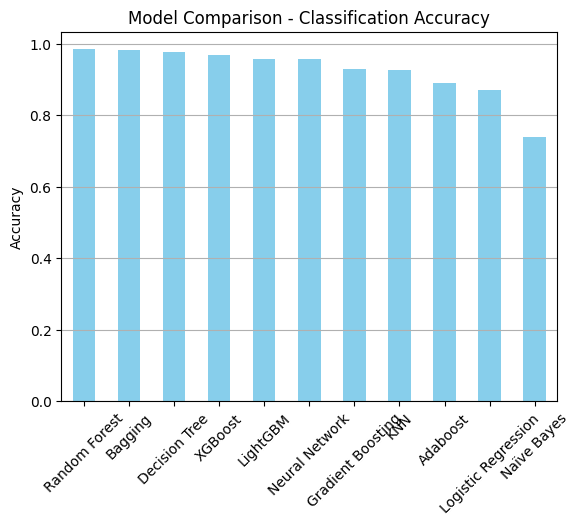

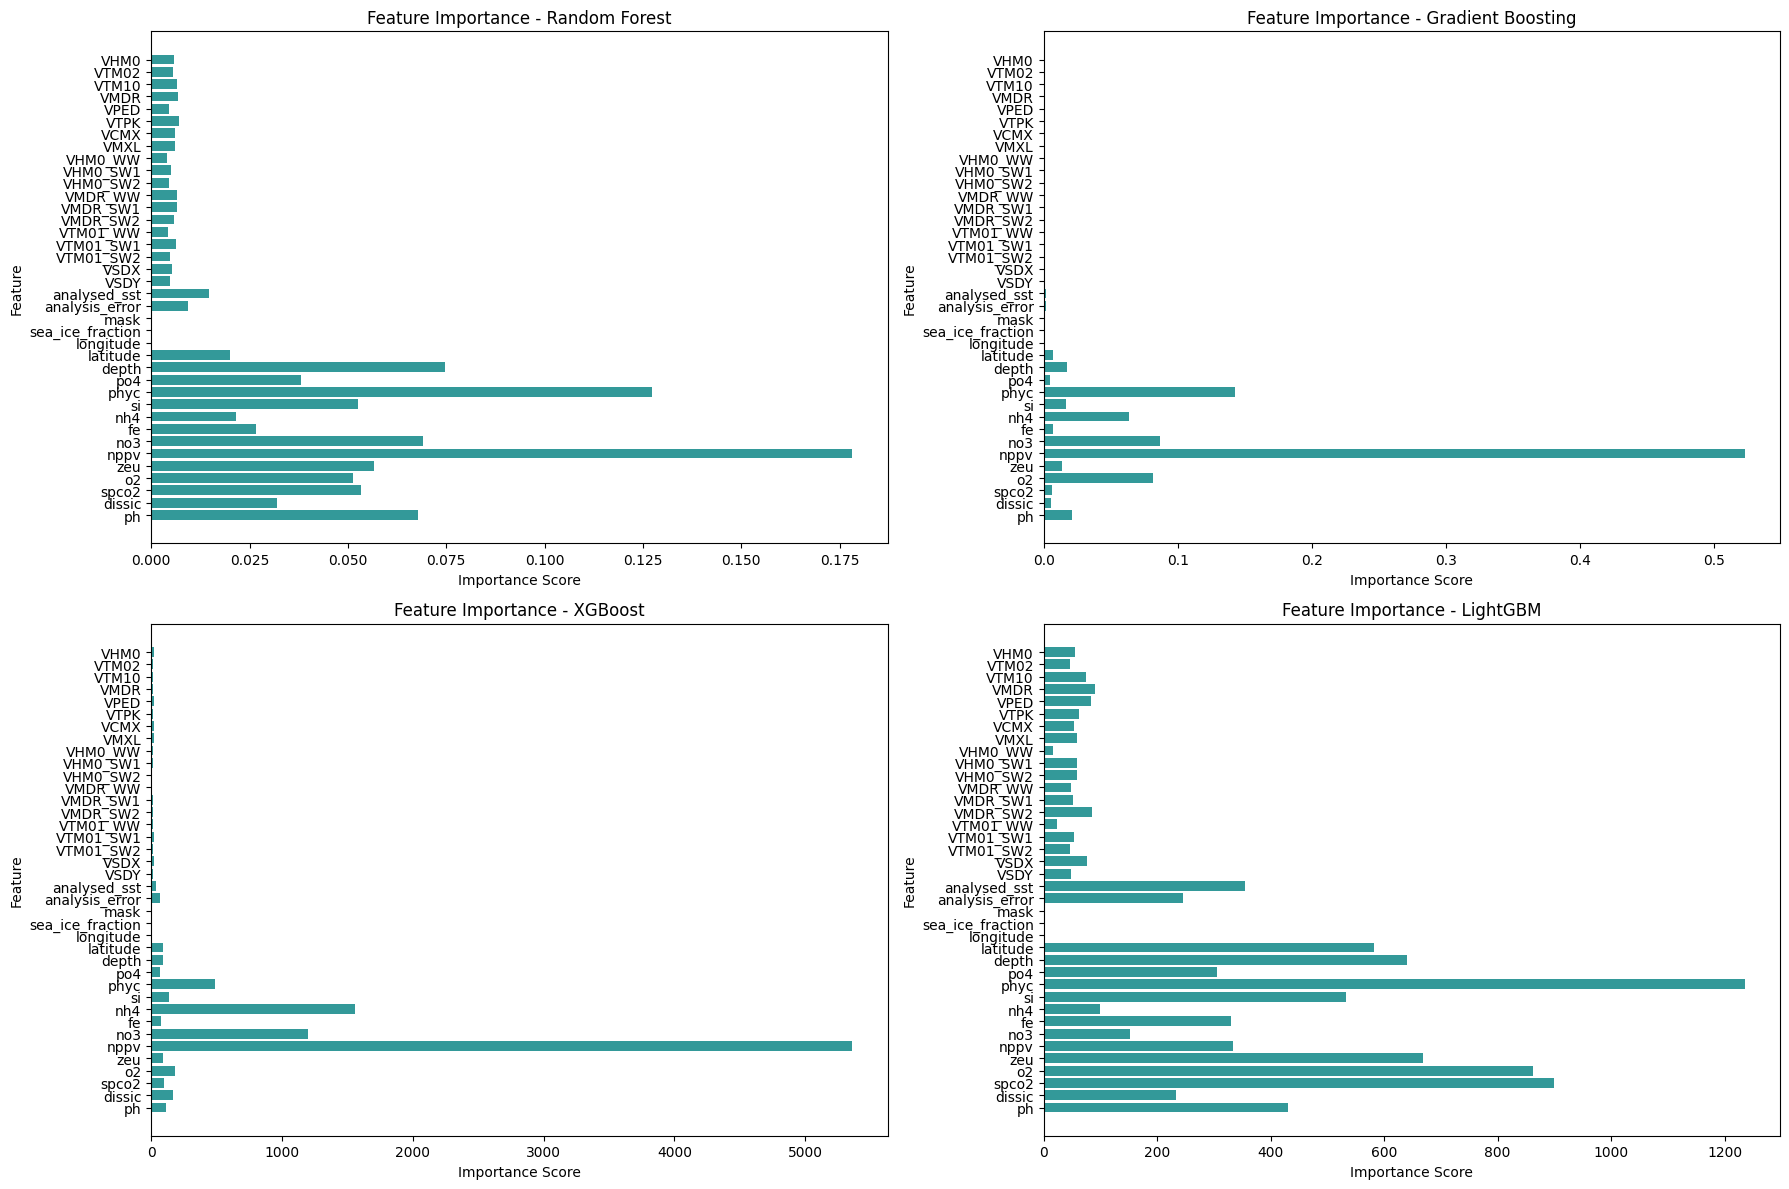

In [14]:
# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')[['Accuracy']]

# Plot Accuracy comparison
plt.figure(figsize=(10, 5))
results_df.sort_values(by='Accuracy', ascending=False).plot(kind='bar', legend=False, color='skyblue')
plt.title("Model Comparison - Classification Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Feature Importance (for tree-based models)
tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']

# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, model_name in enumerate(tree_models):
    if model_name in models:
        model = models[model_name]

        try:
            if model_name == 'XGBoost':
                # Properly extract feature importances from XGBoost
                booster = model.get_booster()
                feature_map = {f'f{i}': name for i, name in enumerate(predictors.columns)}
                raw_scores = booster.get_score(importance_type='gain')
                importances = [raw_scores.get(f'f{i}', 0.0) for i in range(len(predictors.columns))]
            else:
                importances = model.feature_importances_
        except AttributeError:
            print(f"{model_name} does not support feature_importances_")
            continue

        # Plot in corresponding subplot
        axes[idx].barh(predictors.columns, importances, color='teal', alpha=0.8)
        axes[idx].set_title(f'Feature Importance - {model_name}')
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('Importance Score')
        axes[idx].set_ylabel('Feature')

plt.tight_layout()
plt.show()


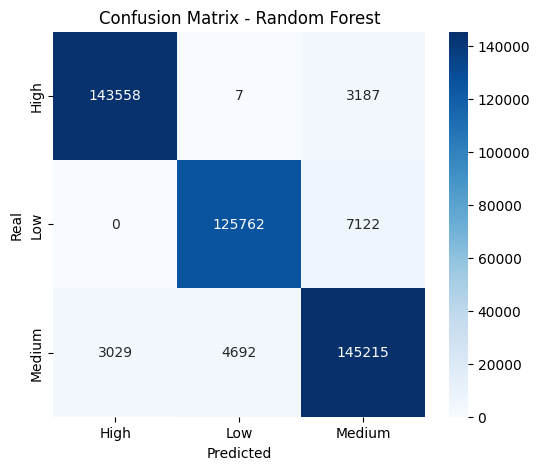

In [11]:
# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Export best model to .pkl file

In [12]:
# Select the best model
best_model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
best_model.fit(X_train, y_train)

# Save model, encoder and scaler for future use
joblib.dump({
    'model': best_model,
    'encoder': encoder,
    'scaler': scaler
}, 'model_2018_2023.pkl')

print("Model saved as 'model_2018_2023.pkl'")

Model saved as 'model_2018_2023.pkl'


In [13]:
unique, counts = np.unique(y_train, return_counts=True)
print("Actual distribution of classes in training:", dict(zip(unique, counts)))

Actual distribution of classes in training: {np.int64(0): np.int64(342421), np.int64(1): np.int64(310061), np.int64(2): np.int64(356852)}
